<a href="https://colab.research.google.com/github/prabh505/Data_simulation/blob/main/Data_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pybullet xgboost scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybullet: filename=pybullet-3.2.7-cp312-cp312-linux_x86_64.whl size=99873156 sha256=32e727f6419857f54847128adff19e136ebbe23b7171eb046d4352f266624ef9
  Stored in directory: /root/.cache/pip/wheels/72/95/1d/b336e5ee612ae9a019bfff4dc0bedd100ee6f0570db205fdf8
Successfully built pybullet


In [2]:
import pybullet as p
import pybullet_data
import numpy as np
import pandas as pd
import random
import math
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt


In [3]:
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())


In [4]:
PARAM_BOUNDS = {
    "mass": (0.1, 10),
    "velocity": (5, 50),
    "angle": (10, 80),
    "drag": (0.0, 0.5),
    "gravity": (5, 15),
    "restitution": (0.1, 0.9)
}


In [5]:
def run_simulation(mass, velocity, angle, drag, gravity, restitution):
    p.resetSimulation()
    p.setGravity(0, 0, -gravity)

    plane = p.loadURDF("plane.urdf")

    col = p.createCollisionShape(p.GEOM_SPHERE, radius=0.05)
    vis = p.createVisualShape(p.GEOM_SPHERE, radius=0.05)

    ball = p.createMultiBody(
        baseMass=mass,
        baseCollisionShapeIndex=col,
        baseVisualShapeIndex=vis,
        basePosition=[0,0,1]
    )

    p.changeDynamics(ball, -1, restitution=restitution, linearDamping=drag)

    theta = math.radians(angle)
    vx = velocity * math.cos(theta)
    vz = velocity * math.sin(theta)
    p.resetBaseVelocity(ball, [vx,0,vz])

    max_height = 0
    distance = 0
    time = 0

    for i in range(3000):
        p.stepSimulation()
        pos, _ = p.getBasePositionAndOrientation(ball)

        max_height = max(max_height, pos[2])
        distance = max(distance, pos[0])
        time += 1/240

        if pos[2] < 0.01:
            break

    return max_height, distance, time


In [6]:
data = []

for _ in tqdm(range(1000)):
    mass = random.uniform(*PARAM_BOUNDS["mass"])
    velocity = random.uniform(*PARAM_BOUNDS["velocity"])
    angle = random.uniform(*PARAM_BOUNDS["angle"])
    drag = random.uniform(*PARAM_BOUNDS["drag"])
    gravity = random.uniform(*PARAM_BOUNDS["gravity"])
    restitution = random.uniform(*PARAM_BOUNDS["restitution"])

    max_h, dist, t = run_simulation(mass, velocity, angle, drag, gravity, restitution)

    data.append([mass, velocity, angle, drag, gravity, restitution, max_h, dist, t])

columns = ["mass","velocity","angle","drag","gravity","restitution",
           "max_height","range","time"]

df = pd.DataFrame(data, columns=columns)
df.to_csv("simulation_data.csv", index=False)
df.head()


100%|██████████| 1000/1000 [00:23<00:00, 42.45it/s]


,mass,velocity,angle,drag,gravity,restitution,max_height,range,time
0,2.316684,18.101436,67.600090,0.218905,7.019649,0.778878,5.487490,5.112406,12.500000
1,7.145422,45.498080,59.238456,0.263283,13.408163,0.801683,6.265178,6.883158,12.500000
2,7.297749,20.486318,35.562629,0.090108,5.468901,0.849667,5.656017,20.639575,12.500000
3,2.739830,37.367947,16.494585,0.037294,14.896017,0.402006,3.410137,38.537223,12.500000
4,6.403208,49.310119,62.620407,0.033374,14.983661,0.555312,23.224253,28.908313,3.491667


In [7]:
X = df.iloc[:, :6]
y = df[["max_height","range","time"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=150, random_state=42),
    "Gradient Boost": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "MLP": MLPRegressor(max_iter=1000, random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42)
}

targets = ["range", "max_height", "time"]

results = []

for target in targets:
    y_t = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_t, test_size=0.2, random_state=42
    )

    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        results.append([name, target, rmse, mae, r2])

results_df = pd.DataFrame(
    results, columns=["Model", "Target", "RMSE", "MAE", "R2"]
)

results_df = results_df.sort_values(
    by=["Target", "R2"], ascending=[True, False]
).reset_index(drop=True)

results_df


,Model,Target,RMSE,MAE,R2
0,XGBoost,max_height,1.452706,0.609044,0.918067
1,Gradient Boost,max_height,1.909189,0.700460,0.858484
2,Random Forest,max_height,2.015509,0.699818,0.842284
3,MLP,max_height,2.451177,1.178346,0.766732
4,Decision Tree,max_height,2.779612,1.098895,0.700032
5,Ridge,max_height,3.531450,2.077686,0.515814
6,Linear Regression,max_height,3.531955,2.106752,0.515675
7,Lasso,max_height,4.252828,2.468745,0.297798
8,SVR,max_height,4.401462,1.904673,0.247858
9,XGBoost,range,2.766121,1.011795,0.959090


In [13]:
results_df.to_csv("model_comparison.csv", index=False)
results_df


,Model,Target,RMSE,MAE,R2
0,XGBoost,max_height,1.452706,0.609044,0.918067
1,Gradient Boost,max_height,1.909189,0.700460,0.858484
2,Random Forest,max_height,2.015509,0.699818,0.842284
3,MLP,max_height,2.451177,1.178346,0.766732
4,Decision Tree,max_height,2.779612,1.098895,0.700032
5,Ridge,max_height,3.531450,2.077686,0.515814
6,Linear Regression,max_height,3.531955,2.106752,0.515675
7,Lasso,max_height,4.252828,2.468745,0.297798
8,SVR,max_height,4.401462,1.904673,0.247858
9,XGBoost,range,2.766121,1.011795,0.959090


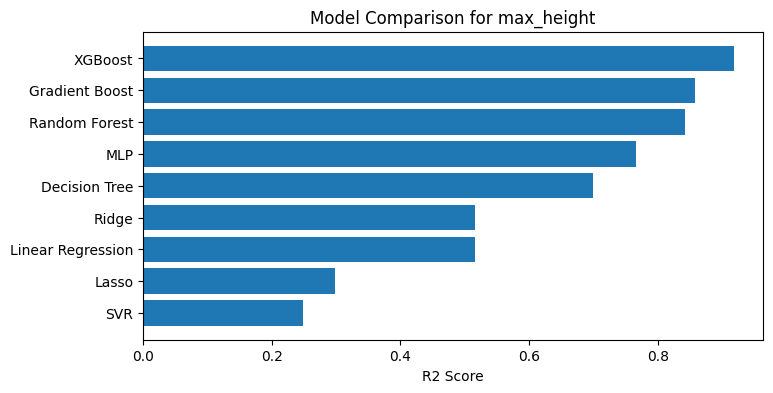

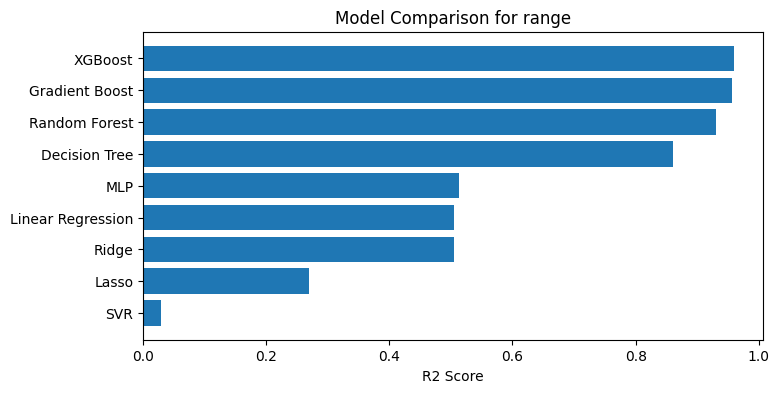

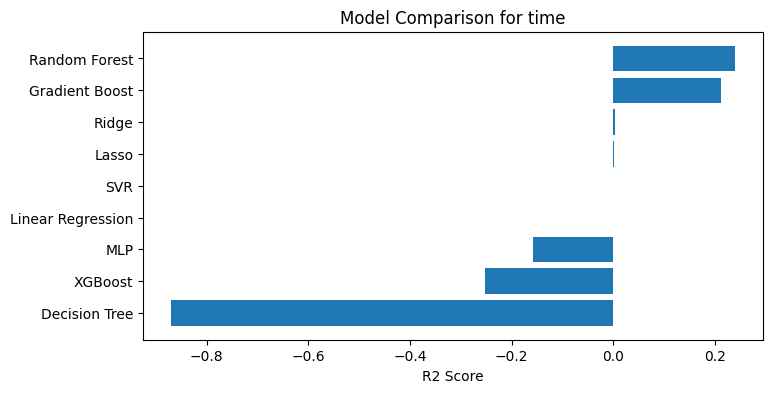

In [14]:
for target in results_df["Target"].unique():
    temp = results_df[results_df["Target"] == target]

    plt.figure(figsize=(8,4))
    plt.barh(temp["Model"], temp["R2"])
    plt.xlabel("R2 Score")
    plt.title(f"Model Comparison for {target}")
    plt.gca().invert_yaxis()
    plt.show()


In [15]:
p.disconnect()


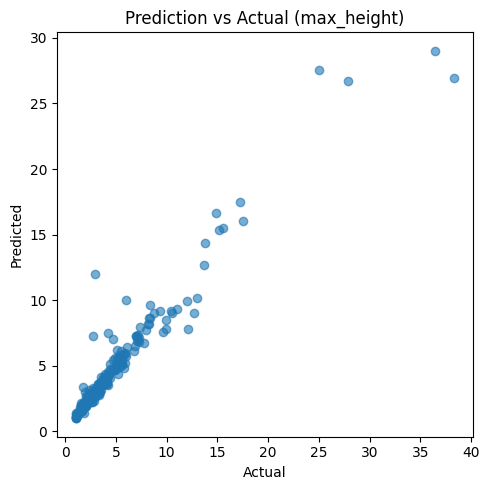

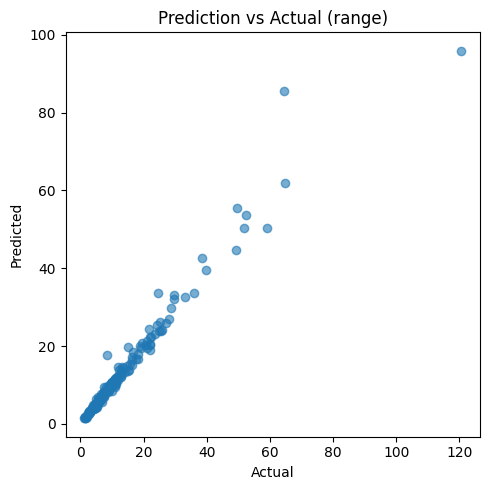

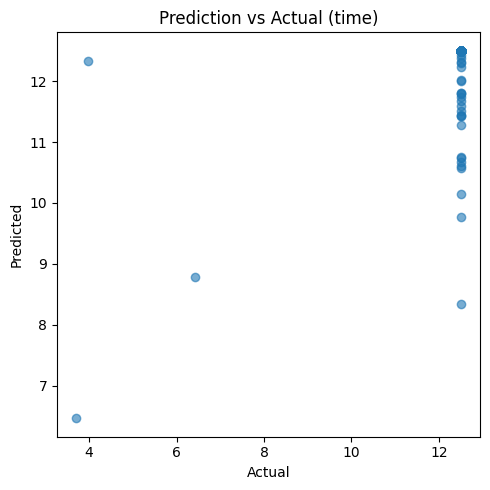

In [17]:
best_models = {}

for target in results_df["Target"].unique():
    best_model_name = results_df[results_df["Target"] == target].iloc[0]["Model"]
    best_models[target] = models[best_model_name]

    y_t = df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_t, test_size=0.2, random_state=42
    )

    best_models[target].fit(X_train, y_train)
    preds = best_models[target].predict(X_test)

    plt.figure(figsize=(5,5))
    plt.scatter(y_test, preds, alpha=0.6)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Prediction vs Actual ({target})")
    plt.tight_layout()
    plt.show()


In [18]:
df.to_csv("simulation_data.csv", index=False)
results_df.to_csv("model_comparison.csv", index=False)

print("CSV files saved")


CSV files saved
